In [32]:
import sys
sys.path.append("../")
from ds4400_final_project.dataset.load_gtzan import load_data_from_file
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# import the data from the 3 seconds and 30 seconds features CSV
X_3, y_3, index_genre_map_3, genre_index_map_3 = load_data_from_file("features_3_sec.csv")
X_30, y_30, index_genre_map_30, genre_index_map_30 = load_data_from_file("features_30_sec.csv")

In [34]:
# split all the data into training and testing sets
TEST_SIZE = 0.33
RANDOM_STATE = 42

x_3_train, x_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=TEST_SIZE, random_state=RANDOM_STATE)
x_30_train, x_30_test, y_30_train, y_30_test = train_test_split(X_30, y_30, test_size=TEST_SIZE, random_state=RANDOM_STATE)

y_3_train, y_3_test, y_30_train, y_30_test = map(torch.LongTensor, [y_3_train, y_3_test, y_30_train, y_30_test])
x_3_train, x_3_test, x_30_train, x_30_test = map(torch.FloatTensor, [x_3_train, x_3_test, x_30_train, x_30_test])


In [35]:
class ShallowModel(nn.Module):

    def __init__(self, num_hidden: int):
        super().__init__()
        self.hidden = nn.Linear(57, num_hidden)
        self.output = nn.Linear(num_hidden, 10)
        

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

In [36]:
class DeepModelTwoHiddenLayer(nn.Module):

    def __init__(self, num_hidden_nodes_1: int, num_hidden_nodes_2: int):
        super().__init__()
        self.hidden1 = nn.Linear(57, num_hidden_nodes_1)
        self.hidden2 = nn.Linear(num_hidden_nodes_1, num_hidden_nodes_2)
        self.output = nn.Linear(num_hidden_nodes_2, 10)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [37]:
class GTZANDataset(Dataset):

    def __init__(self, x_data, y_data):
        self._x_data = x_data
        self._y_data = y_data

    def __len__(self):
        return len(self._x_data)
        
    def __getitem__(self, idx):
        return [self._x_data[idx], self._y_data[idx]]

In [38]:
def train_model(model, loss_func, x_train, y_train, epochs: int, lr: float, l2_reg: float, batch_size: int, verbose = False):
	dataset = GTZANDataset(x_train, y_train)
	dataloader = DataLoader(dataset, batch_size=batch_size)

	# set the model to training mode
	model.train()

	# save average losses every epoch
	losses = []

	# optimize the model
	for epoch in range(epochs):

		optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, weight_decay=l2_reg)

		losses_each_batch = []

		for batch, (x, y) in enumerate(dataloader):

			y_pred = model(x)

			loss = loss_func(y_pred, y)

			# backpropogation
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			with torch.no_grad():
				for param in model.parameters():
					param -= lr * param.grad

			# save the loss for this batch
			losses_each_batch.append(loss.item())

			if verbose and batch % (batch_size // 10) == 0:
				avg_running_loss = sum(losses_each_batch) / len(losses_each_batch)
				current = batch * len(x)
				# print(f"Epoch [{epoch:03}] Batch [{batch:03}] avg_running_loss: {avg_running_loss:>7f} [{current:>5d}/{len(dataset):>5d}]")

		# average all the batch losses for this epoch and save it
		avg_loss_epoch = sum(losses_each_batch) / len(losses_each_batch)
		losses.append(avg_loss_epoch)

		if verbose and (epoch % 50 == 0):
			print(f"Epoch [{epoch:03}]: average loss: {avg_loss_epoch:>7f}")

	# set the model to evaluation mode
	model.eval()
	return model, losses

In [39]:
def run_training_experiments(experiment_configs, x_train, y_train):

    models = {}

    for model_id, config in experiment_configs.items():
        model_class = config["model_class"]
        model_kwargs = config["model_kwargs"] if "model_kwargs" in config.keys() else {} 
        model_instance = model_class(**model_kwargs)
        loss_func_class = config["loss_func_class"]
        loss_func_kwargs = config["loss_func_kwargs"] if "loss_func_kwargs" in config.keys() else {}
        loss_func = loss_func_class(**loss_func_kwargs)

        print(f"TRAINING MODEL: {model_id}")

        output_model, losses = train_model(
            model=model_instance,
            loss_func=loss_func,
            x_train=x_train,
            y_train=y_train,
            epochs=config["epoch"],
            lr=config["lr"],
            l2_reg=config["l2_reg"],
            batch_size=config["batch_size"],
            verbose=config["verbose"]
        )

        models[model_id] = {"model": output_model, "losses": losses}

    return models


In [86]:
EPOCHS = 5000
L2_REGULARIZATION = 0.001
BATCH_SIZE = 64

lr_experiment_dict_3_sec = {}
lr_experiment_dict_30_sec = {}

for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f"EVALUATING ON LEARNING RATE = {lr}")
    print("------------------------------------")
    experiments = {
        "Shallow Model 32 Hidden Nodes": {
            "model_class": ShallowModel,
            "model_kwargs": {
                "num_hidden": 32
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "Shallow Model 64 Hidden Nodes": {
            "model_class": ShallowModel,
            "model_kwargs": {
                "num_hidden": 64
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "Shallow Model 128 Hidden Nodes": {
            "model_class": ShallowModel,
            "model_kwargs": {
                "num_hidden": 128
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "Deep Model 2 Hidden Layers 64 - 32 nodes": {
            "model_class": DeepModelTwoHiddenLayer,
            "model_kwargs": {
                "num_hidden_nodes_1": 64,
                "num_hidden_nodes_2": 32
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
        "Deep Model 2 Hidden Layers 128 - 64 nodes": {
            "model_class": DeepModelTwoHiddenLayer,
            "model_kwargs": {
                "num_hidden_nodes_1": 128,
                "num_hidden_nodes_2": 64
            },
            "loss_func_class": nn.CrossEntropyLoss,
            "epoch": EPOCHS,
            "lr": lr,
            "l2_reg": L2_REGULARIZATION,
            "batch_size": BATCH_SIZE,
            "verbose": True
        },
    }

    three_sec_training_results = run_training_experiments(experiment_configs=experiments, x_train=x_3_train, y_train=y_3_train)
    thirty_sec_training_results = run_training_experiments(experiment_configs=experiments, x_train=x_30_train, y_train=y_30_train)
    lr_experiment_dict_3_sec[str(lr)] = three_sec_training_results
    lr_experiment_dict_30_sec[str(lr)] = thirty_sec_training_results

EVALUATING ON LEARNING RATE = 0.1
------------------------------------
TRAINING MODEL: Shallow Model 32 Hidden Nodes
Epoch [000]: average loss: 1.466159
Epoch [050]: average loss: 0.324829
Epoch [100]: average loss: 0.255848
Epoch [150]: average loss: 0.228646
Epoch [200]: average loss: 0.216152
Epoch [250]: average loss: 0.207160
Epoch [300]: average loss: 0.201494
Epoch [350]: average loss: 0.198315
Epoch [400]: average loss: 0.194576
Epoch [450]: average loss: 0.190827
Epoch [500]: average loss: 0.189384
Epoch [550]: average loss: 0.188518
Epoch [600]: average loss: 0.187355
Epoch [650]: average loss: 0.186889
Epoch [700]: average loss: 0.183719
Epoch [750]: average loss: 0.182527
Epoch [800]: average loss: 0.180990
Epoch [850]: average loss: 0.179180
Epoch [900]: average loss: 0.178805
Epoch [950]: average loss: 0.177985
Epoch [1000]: average loss: 0.177880
Epoch [1050]: average loss: 0.177602
Epoch [1100]: average loss: 0.177136
Epoch [1150]: average loss: 0.177360
Epoch [1200]: a

KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, x_data, y_data, batch_size):
	dataset = GTZANDataset(x_data, y_data)
	dataloader = DataLoader(dataset, batch_size=batch_size)

	model.eval()

	correct = 0
	pred = 0
    
	for x, y in dataloader:
		y_pred = model(x)

		y_pred_softmax = torch.log_softmax(y_pred, dim=1)
		_, y_pred_tags = torch.max(y_pred_softmax, dim=1)

		correct_pred = (y_pred_tags == y).float()
		correct += int(correct_pred.sum())
		pred += len(correct_pred)

	acc = correct / pred
	return acc

In [ ]:
def plot_loss(outputs, title):
    legend = []
    for model_id, output in outputs.items():
        legend.append(model_id)
        losses = output["losses"]
        plt.plot(range(len(losses)), losses)
    plt.legend(legend, loc='upper left')
    plt.title(title)
    plt.show()

In [ ]:
def plot_accuracy_bar_chart(accuracies, title):
    labels = list(accuracies.keys())
    formatted_labels = []
    for label in labels:
        second_space_idx = label.index("Model") + 5
        formatted_labels.append(label[:second_space_idx] + "\n" + label[second_space_idx+1:])
    
    train_accuracies = [accuracies[labels[i]]["train"] for i in range(len(labels))]
    test_accuracies = [accuracies[labels[i]]["test"] for i in range(len(labels))]
    N = len(labels)
    indices = np.arange(N)
    width = 0.35
    plt.bar(indices, train_accuracies, width, label="Training Accuracy")
    plt.bar(indices, test_accuracies, width, label="Testing Accuracy")

    plt.ylabel("Accuracy")
    plt.title(title)

    plt.xticks(
        indices + width / 2,
        formatted_labels,
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-small'  
    )

    plt.legend(loc="best")
    plt.show()

In [ ]:
def get_best_performing_learning_rate(experiment_dict):
    best_lr = None
    best_avg_acc = None

    for lr, experiments in experiment_dict.items():
        test_accuracy = []
        for result in experiments.values():
            model = result["model"]
            test_acc = evaluate_model(model, x_30_test, y_30_test, batch_size=BATCH_SIZE)
            test_accuracy.append(test_acc)
        avg_acc = sum(test_accuracy) / len(test_accuracy)
        if best_lr is None:
            best_lr = lr
            best_avg_acc = avg_acc
        elif avg_acc > best_avg_acc:
            best_lr = lr
            best_avg_acc = avg_acc

    return best_lr

In [ ]:
best_3_sec_lr = str(get_best_performing_learning_rate(lr_experiment_dict_3_sec))
best_30_sec_lr = str(get_best_performing_learning_rate(lr_experiment_dict_30_sec))

best_3_sec_experiments = lr_experiment_dict_3_sec[best_3_sec_lr]
best_30_sec_experiments = lr_experiment_dict_30_sec[best_30_sec_lr]

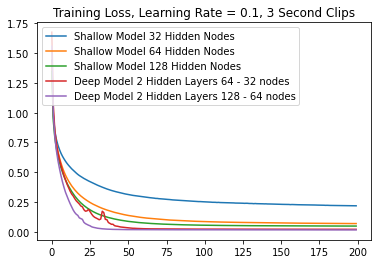

In [ ]:
plot_loss(best_3_sec_experiments, f"Training Loss, Learning Rate = {best_3_sec_lr}, 3 Second Clips")

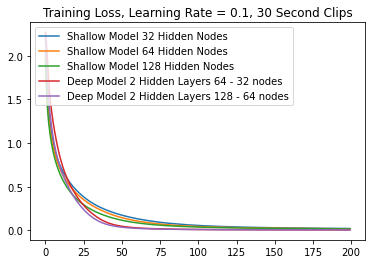

In [ ]:
plot_loss(best_30_sec_experiments, f"Training Loss, Learning Rate = {best_30_sec_lr}, 30 Second Clips")

In [ ]:
three_sec_accuracies = {}
thirty_sec_accuracies = {}

for title, result in best_3_sec_experiments.items():
    model = result["model"]
    train_acc = evaluate_model(model, x_3_train, y_3_train, batch_size=BATCH_SIZE)
    test_acc = evaluate_model(model, x_3_test, y_3_test, batch_size=BATCH_SIZE)
    three_sec_accuracies[title] = {"train": train_acc, "test": test_acc}

for title, result in best_30_sec_experiments.items():
    model = result["model"]
    train_acc = evaluate_model(model, x_30_train, y_30_train, batch_size=BATCH_SIZE)
    test_acc = evaluate_model(model, x_30_test, y_30_test, batch_size=BATCH_SIZE)
    thirty_sec_accuracies[title] = {"train": train_acc, "test": test_acc}

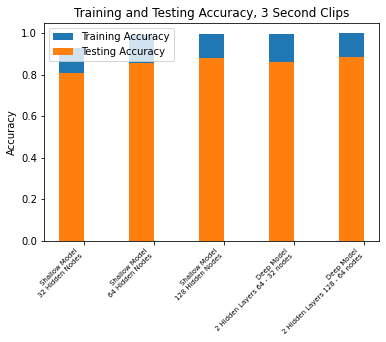

In [ ]:
plot_accuracy_bar_chart(three_sec_accuracies, "Training and Testing Accuracy, 3 Second Clips")

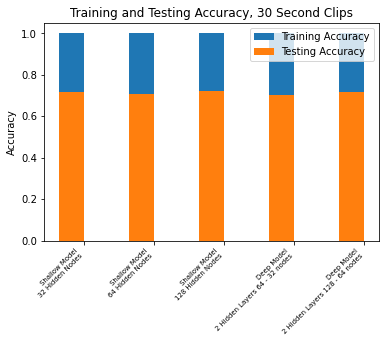

In [ ]:
plot_accuracy_bar_chart(thirty_sec_accuracies, "Training and Testing Accuracy, 30 Second Clips")

In [ ]:
class DeepModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(57, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.hidden4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.hidden4(x))
        x = self.output(x)
        return x

more_experiments = {
    "Deep Model": {
        "model_class": DeepModel,
        "model_kwargs": {},
        "loss_func_class": nn.CrossEntropyLoss,
        "epoch": EPOCHS,
        "lr": 0.01,
        "l2_reg": L2_REGULARIZATION,
        "batch_size": BATCH_SIZE,
        "verbose": True
    }
}

res_3 = run_training_experiments(more_experiments, x_3_train, y_3_train)
more_experiments["Deep Model"]["lr"] = 0.1
res_30 = run_training_experiments(more_experiments, x_30_train, y_30_train)

TRAINING MODEL: Deep Model
Epoch [000]: average loss: 2.302869
Epoch [050]: average loss: 0.184206
Epoch [100]: average loss: 0.013664
Epoch [150]: average loss: 0.008740


KeyboardInterrupt: 

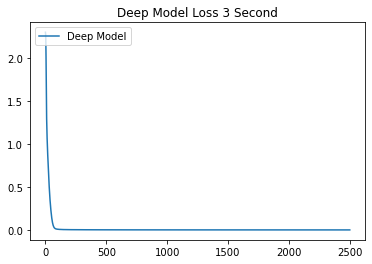

In [ ]:
plot_loss(res_3, "Deep Model Loss 3 Second")

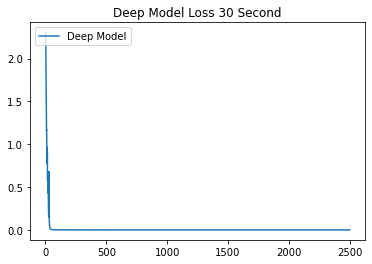

In [ ]:
plot_loss(res_30, "Deep Model Loss 30 Second")

In [ ]:
res_3_accuracies = {}
res_30_accuracies = {}

for title, result in res_3.items():
    model = result["model"]
    train_acc = evaluate_model(model, x_3_train, y_3_train, batch_size=BATCH_SIZE)
    test_acc = evaluate_model(model, x_3_test, y_3_test, batch_size=BATCH_SIZE)
    res_3_accuracies[title] = {"train": train_acc, "test": test_acc}
for title, result in res_30.items():
    model = result["model"]
    train_acc = evaluate_model(model, x_30_train, y_30_train, batch_size=BATCH_SIZE)
    test_acc = evaluate_model(model, x_30_test, y_30_test, batch_size=BATCH_SIZE)
    res_30_accuracies[title] = {"train": train_acc, "test": test_acc}

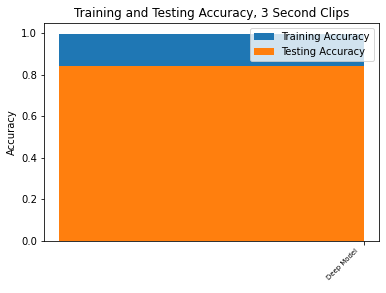

In [ ]:
plot_accuracy_bar_chart(res_3_accuracies, "Training and Testing Accuracy, 3 Second Clips")

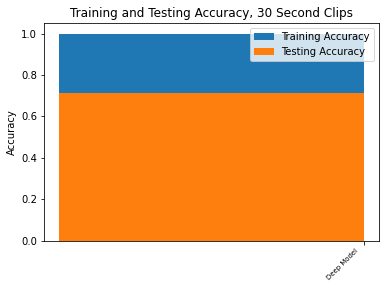

In [ ]:
plot_accuracy_bar_chart(res_30_accuracies, "Training and Testing Accuracy, 30 Second Clips")